# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

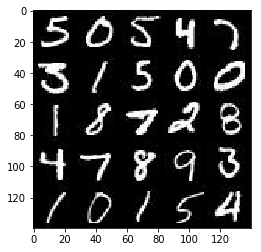

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

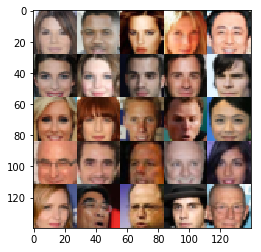

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    images = tf.placeholder(tf.float32, shape=([None, image_width, image_height, image_channels]), name='images')
    z_tensor = tf.placeholder(tf.float32, shape=([None, z_dim]), name='z_tensor')
    learning_rate_variable = tf.placeholder(tf.float32, name='learning_rate_variable')
    
    return images, z_tensor, learning_rate_variable


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/usr/lo

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [9]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    drop_rate = 0.7
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu_x1 = tf.maximum(alpha * x1, x1)
        
        # Hidden layer 1
        x2 = tf.layers.conv2d(relu_x1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        normal_x2 = tf.layers.batch_normalization(x2, training=True)
        relu_x2 = tf.maximum(alpha * normal_x2, normal_x2)
        dropout_x2 = tf.layers.dropout(relu_x2, drop_rate, training=True)
        
        # Hidden layer 2
        x3 = tf.layers.conv2d(relu_x2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        normal_x3 = tf.layers.batch_normalization(x3, training=True)
        relu_x3 = tf.maximum(alpha * normal_x3, normal_x3)
        dropout_x3 = tf.layers.dropout(relu_x3, drop_rate, training=True)
        
        # Flatten image
        flat = tf.contrib.layers.flatten(relu_x3)
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    drop_rate = 0.5
    
    with tf.variable_scope('generator', reuse= not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.layers.dropout(x2, drop_rate, training=True)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=1, padding='valid', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.layers.dropout(x3, drop_rate, training=True)
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 3, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        x4 = tf.layers.dropout(x4, drop_rate, training=True)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())

    return tf.tanh(logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    print_every = 50
    show_every = 250
    steps = 0
    
    samples, image_width, image_height, image_channels = data_shape
    images_real, z_tensor, learning_rate_variable = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(images_real, z_tensor, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate_variable, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={images_real: batch_images, z_tensor: batch_z, learning_rate_variable: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={z_tensor: batch_z, images_real: batch_images, learning_rate_variable: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={z_tensor: batch_z, images_real: batch_images, learning_rate_variable: learning_rate})

                if steps % show_every == 0:
                    show_generator_output(sess, 16, z_tensor, image_channels, data_image_mode)
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({z_tensor: batch_z, images_real: batch_images})
                    train_loss_g = g_loss.eval({z_tensor: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

    saver = tf.train.Saver()
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.2624... Generator Loss: 2.7800
Epoch 1/2... Discriminator Loss: 0.8854... Generator Loss: 1.0011
Epoch 1/2... Discriminator Loss: 0.8469... Generator Loss: 1.4977
Epoch 1/2... Discriminator Loss: 1.4793... Generator Loss: 0.7065


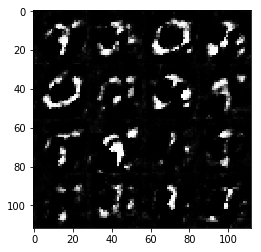

Epoch 1/2... Discriminator Loss: 1.6687... Generator Loss: 0.4988
Epoch 1/2... Discriminator Loss: 1.2141... Generator Loss: 0.6391
Epoch 1/2... Discriminator Loss: 1.0407... Generator Loss: 0.8882
Epoch 1/2... Discriminator Loss: 1.2336... Generator Loss: 1.8239
Epoch 1/2... Discriminator Loss: 1.2322... Generator Loss: 0.6255


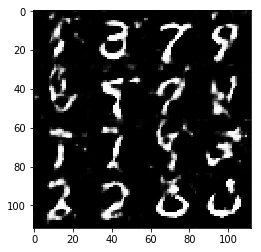

Epoch 1/2... Discriminator Loss: 2.0115... Generator Loss: 2.1703
Epoch 1/2... Discriminator Loss: 1.5057... Generator Loss: 0.5533
Epoch 1/2... Discriminator Loss: 0.8721... Generator Loss: 1.1021
Epoch 1/2... Discriminator Loss: 0.8409... Generator Loss: 1.0865
Epoch 1/2... Discriminator Loss: 0.7960... Generator Loss: 1.2247


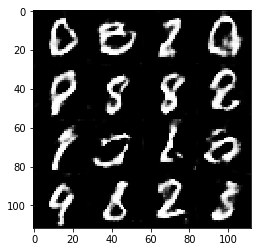

Epoch 1/2... Discriminator Loss: 1.0773... Generator Loss: 0.8219
Epoch 1/2... Discriminator Loss: 0.7322... Generator Loss: 1.2814
Epoch 1/2... Discriminator Loss: 0.9692... Generator Loss: 0.9457
Epoch 1/2... Discriminator Loss: 1.5798... Generator Loss: 1.9966
Epoch 1/2... Discriminator Loss: 0.7077... Generator Loss: 1.1511


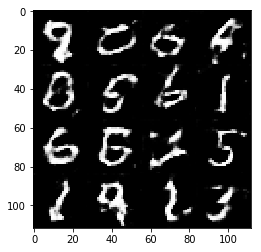

Epoch 1/2... Discriminator Loss: 2.5617... Generator Loss: 3.6342
Epoch 1/2... Discriminator Loss: 1.1452... Generator Loss: 1.2435
Epoch 1/2... Discriminator Loss: 0.8031... Generator Loss: 3.0609
Epoch 1/2... Discriminator Loss: 0.9821... Generator Loss: 0.9309
Epoch 1/2... Discriminator Loss: 2.2383... Generator Loss: 4.6643


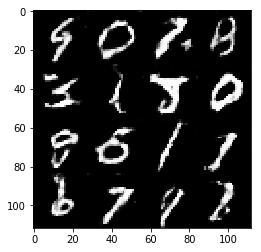

Epoch 1/2... Discriminator Loss: 0.6415... Generator Loss: 2.1827
Epoch 1/2... Discriminator Loss: 0.4580... Generator Loss: 1.9119
Epoch 1/2... Discriminator Loss: 0.4782... Generator Loss: 2.0413
Epoch 1/2... Discriminator Loss: 1.1648... Generator Loss: 0.8043
Epoch 1/2... Discriminator Loss: 0.7929... Generator Loss: 3.0649


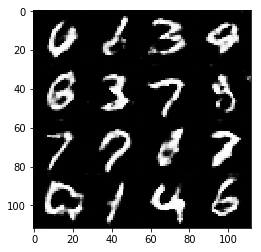

Epoch 1/2... Discriminator Loss: 1.6949... Generator Loss: 0.4457
Epoch 1/2... Discriminator Loss: 0.5292... Generator Loss: 2.3400
Epoch 1/2... Discriminator Loss: 0.9149... Generator Loss: 0.9095
Epoch 1/2... Discriminator Loss: 0.8219... Generator Loss: 1.4567
Epoch 1/2... Discriminator Loss: 0.6129... Generator Loss: 2.7924


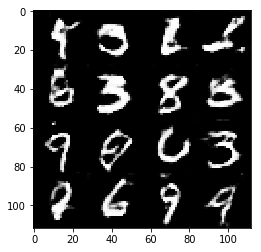

Epoch 1/2... Discriminator Loss: 0.5059... Generator Loss: 3.1336
Epoch 1/2... Discriminator Loss: 0.6021... Generator Loss: 1.3399
Epoch 1/2... Discriminator Loss: 0.5266... Generator Loss: 2.1241
Epoch 2/2... Discriminator Loss: 0.4642... Generator Loss: 2.8620
Epoch 2/2... Discriminator Loss: 0.4339... Generator Loss: 3.1280


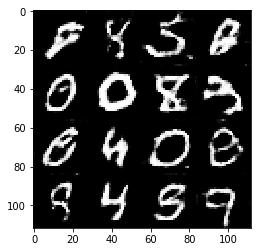

Epoch 2/2... Discriminator Loss: 0.5131... Generator Loss: 2.4970
Epoch 2/2... Discriminator Loss: 0.4553... Generator Loss: 2.4688
Epoch 2/2... Discriminator Loss: 0.4387... Generator Loss: 3.2473
Epoch 2/2... Discriminator Loss: 0.5231... Generator Loss: 2.1552
Epoch 2/2... Discriminator Loss: 0.5609... Generator Loss: 2.4359


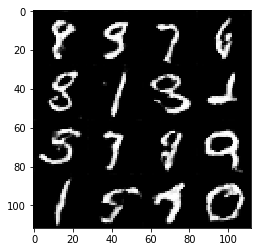

Epoch 2/2... Discriminator Loss: 0.5042... Generator Loss: 3.0811
Epoch 2/2... Discriminator Loss: 0.5861... Generator Loss: 1.7348
Epoch 2/2... Discriminator Loss: 0.4603... Generator Loss: 2.9389
Epoch 2/2... Discriminator Loss: 0.4888... Generator Loss: 4.0837
Epoch 2/2... Discriminator Loss: 0.7744... Generator Loss: 1.3536


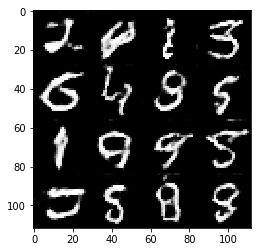

Epoch 2/2... Discriminator Loss: 0.6243... Generator Loss: 2.6035
Epoch 2/2... Discriminator Loss: 0.5405... Generator Loss: 3.5302
Epoch 2/2... Discriminator Loss: 0.4837... Generator Loss: 3.7412
Epoch 2/2... Discriminator Loss: 0.3856... Generator Loss: 2.8970
Epoch 2/2... Discriminator Loss: 0.4033... Generator Loss: 2.9923


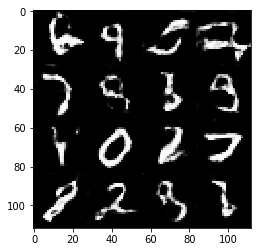

Epoch 2/2... Discriminator Loss: 0.4666... Generator Loss: 2.8612
Epoch 2/2... Discriminator Loss: 1.0063... Generator Loss: 1.4073
Epoch 2/2... Discriminator Loss: 0.4021... Generator Loss: 3.3342
Epoch 2/2... Discriminator Loss: 0.3958... Generator Loss: 3.7769
Epoch 2/2... Discriminator Loss: 0.4606... Generator Loss: 4.2708


In [ ]:
batch_size = 32
z_dim = 128
learning_rate = 0.001
beta1 = 0.4

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 0.8622
Epoch 1/1... Discriminator Loss: 0.8569... Generator Loss: 1.8543
Epoch 1/1... Discriminator Loss: 1.7144... Generator Loss: 0.6044


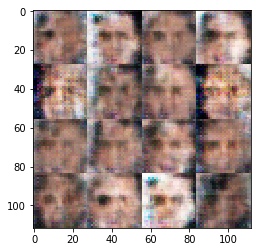

Epoch 1/1... Discriminator Loss: 1.5557... Generator Loss: 0.7445
Epoch 1/1... Discriminator Loss: 1.6385... Generator Loss: 0.7082
Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.5525
Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 1.1554
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.9747


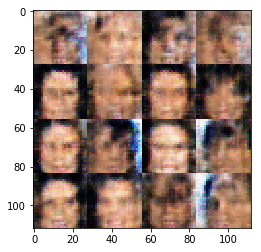

Epoch 1/1... Discriminator Loss: 1.6350... Generator Loss: 0.5061
Epoch 1/1... Discriminator Loss: 1.2588... Generator Loss: 0.8211
Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.9152
Epoch 1/1... Discriminator Loss: 1.3218... Generator Loss: 0.9623
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.6661


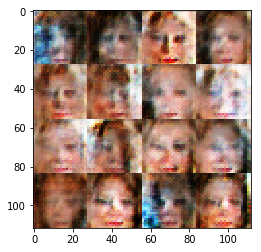

Epoch 1/1... Discriminator Loss: 1.0262... Generator Loss: 0.9224
Epoch 1/1... Discriminator Loss: 1.6783... Generator Loss: 1.4658
Epoch 1/1... Discriminator Loss: 1.1308... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.6779... Generator Loss: 0.6179
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.5542


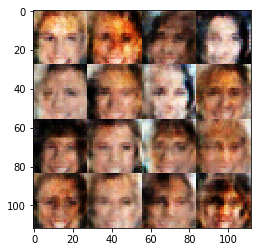

Epoch 1/1... Discriminator Loss: 1.2614... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.7517
Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 1.0266
Epoch 1/1... Discriminator Loss: 1.2964... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.8567


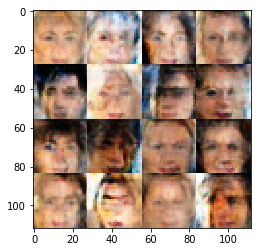

Epoch 1/1... Discriminator Loss: 1.2881... Generator Loss: 0.9135
Epoch 1/1... Discriminator Loss: 1.4818... Generator Loss: 0.4730
Epoch 1/1... Discriminator Loss: 1.2368... Generator Loss: 0.9077
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.6523
Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 0.6321


Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.8237
Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 1.1704... Generator Loss: 1.3204
Epoch 1/1... Discriminator Loss: 1.1089... Generator Loss: 1.0513
Epoch 1/1... Discriminator Loss: 1.0769... Generator Loss: 0.9505


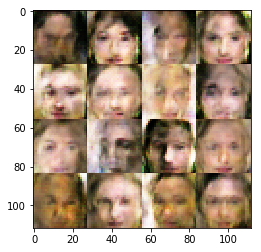

Epoch 1/1... Discriminator Loss: 1.1274... Generator Loss: 0.9072
Epoch 1/1... Discriminator Loss: 1.2393... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 1.0090... Generator Loss: 1.0267
Epoch 1/1... Discriminator Loss: 1.1239... Generator Loss: 0.8304
Epoch 1/1... Discriminator Loss: 1.1884... Generator Loss: 0.7354


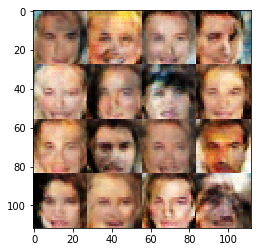

Epoch 1/1... Discriminator Loss: 1.4424... Generator Loss: 0.4732
Epoch 1/1... Discriminator Loss: 1.2216... Generator Loss: 1.2753
Epoch 1/1... Discriminator Loss: 1.5799... Generator Loss: 1.8324
Epoch 1/1... Discriminator Loss: 0.8990... Generator Loss: 1.3045
Epoch 1/1... Discriminator Loss: 1.2997... Generator Loss: 0.5924


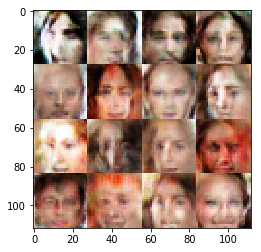

Epoch 1/1... Discriminator Loss: 1.1876... Generator Loss: 0.7190
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.4942
Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 1.0001... Generator Loss: 0.9510
Epoch 1/1... Discriminator Loss: 0.9707... Generator Loss: 1.2671


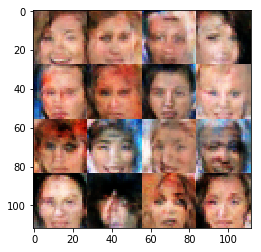

Epoch 1/1... Discriminator Loss: 0.8092... Generator Loss: 1.1752
Epoch 1/1... Discriminator Loss: 1.0693... Generator Loss: 0.8139
Epoch 1/1... Discriminator Loss: 1.1028... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.0136... Generator Loss: 1.7486
Epoch 1/1... Discriminator Loss: 0.9064... Generator Loss: 1.1600


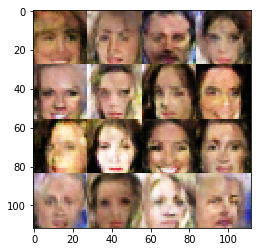

Epoch 1/1... Discriminator Loss: 0.7889... Generator Loss: 1.3715
Epoch 1/1... Discriminator Loss: 0.7602... Generator Loss: 1.2173
Epoch 1/1... Discriminator Loss: 0.9467... Generator Loss: 0.8565
Epoch 1/1... Discriminator Loss: 0.8357... Generator Loss: 0.9981
Epoch 1/1... Discriminator Loss: 0.7398... Generator Loss: 2.0493


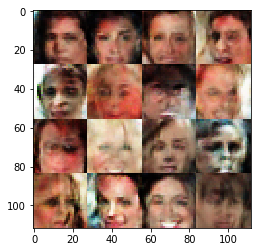

Epoch 1/1... Discriminator Loss: 0.9133... Generator Loss: 0.9640
Epoch 1/1... Discriminator Loss: 0.8790... Generator Loss: 1.3755
Epoch 1/1... Discriminator Loss: 1.0046... Generator Loss: 0.9893
Epoch 1/1... Discriminator Loss: 0.8349... Generator Loss: 2.0454
Epoch 1/1... Discriminator Loss: 0.7049... Generator Loss: 2.2491


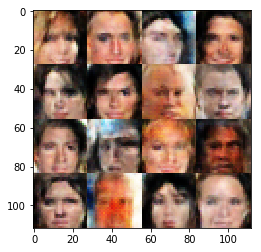

Epoch 1/1... Discriminator Loss: 0.6496... Generator Loss: 1.6446
Epoch 1/1... Discriminator Loss: 0.8885... Generator Loss: 0.9983
Epoch 1/1... Discriminator Loss: 0.6892... Generator Loss: 1.7221
Epoch 1/1... Discriminator Loss: 0.5549... Generator Loss: 2.0757
Epoch 1/1... Discriminator Loss: 0.9059... Generator Loss: 1.1485


Epoch 1/1... Discriminator Loss: 0.6971... Generator Loss: 1.1836
Epoch 1/1... Discriminator Loss: 0.6224... Generator Loss: 2.2713
Epoch 1/1... Discriminator Loss: 0.6906... Generator Loss: 1.1346
Epoch 1/1... Discriminator Loss: 1.1412... Generator Loss: 0.9577
Epoch 1/1... Discriminator Loss: 0.6436... Generator Loss: 1.5910


Epoch 1/1... Discriminator Loss: 0.6865... Generator Loss: 2.7612
Epoch 1/1... Discriminator Loss: 0.5648... Generator Loss: 2.0535
Epoch 1/1... Discriminator Loss: 0.8723... Generator Loss: 1.0441
Epoch 1/1... Discriminator Loss: 0.5747... Generator Loss: 1.6127
Epoch 1/1... Discriminator Loss: 0.5709... Generator Loss: 2.5317


Epoch 1/1... Discriminator Loss: 0.4936... Generator Loss: 3.0326
Epoch 1/1... Discriminator Loss: 0.7312... Generator Loss: 1.3414
Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 3.1905
Epoch 1/1... Discriminator Loss: 0.5651... Generator Loss: 2.3909
Epoch 1/1... Discriminator Loss: 0.6998... Generator Loss: 1.5287


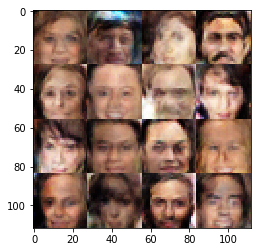

Epoch 1/1... Discriminator Loss: 0.5839... Generator Loss: 2.3767
Epoch 1/1... Discriminator Loss: 1.0623... Generator Loss: 0.8435
Epoch 1/1... Discriminator Loss: 0.6481... Generator Loss: 1.6597
Epoch 1/1... Discriminator Loss: 1.0151... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 0.4676... Generator Loss: 2.4486


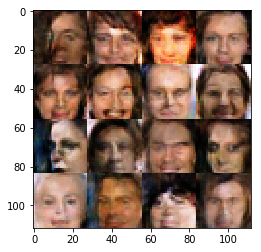

Epoch 1/1... Discriminator Loss: 0.5721... Generator Loss: 1.6301
Epoch 1/1... Discriminator Loss: 0.9930... Generator Loss: 1.3294
Epoch 1/1... Discriminator Loss: 0.6011... Generator Loss: 2.2572
Epoch 1/1... Discriminator Loss: 0.4670... Generator Loss: 2.6223
Epoch 1/1... Discriminator Loss: 0.5043... Generator Loss: 2.8269


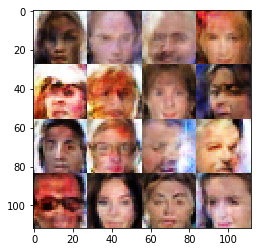

Epoch 1/1... Discriminator Loss: 0.6154... Generator Loss: 2.2579
Epoch 1/1... Discriminator Loss: 0.6926... Generator Loss: 1.4988
Epoch 1/1... Discriminator Loss: 0.5306... Generator Loss: 2.5643
Epoch 1/1... Discriminator Loss: 1.0634... Generator Loss: 4.0874
Epoch 1/1... Discriminator Loss: 0.5727... Generator Loss: 2.3054


Epoch 1/1... Discriminator Loss: 0.4442... Generator Loss: 3.1092


In [ ]:
batch_size = 32
z_dim = 128
learning_rate = 0.001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.